# Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Load dataset

In [ ]:
# Load Iris dataset
iris = load_iris()
X_iris = iris.data
target = iris.target

# PCA function

In [ ]:
def covariance_matrix(X):
    n_samples, n_features = X.shape
    mean_vector = np.mean(X, axis=0)
    centered_data = X - mean_vector
    cov_matrix = np.dot(centered_data.T, centered_data) / (n_samples - 1)
    return cov_matrix

def power_iteration(A, num_iterations=1000):
    n, _ = A.shape
    b_k = np.random.rand(n)

    for _ in range(num_iterations):
        # Power iteration
        b_k1 = np.dot(A, b_k)
        b_k1_norm = np.linalg.norm(b_k1)
        b_k = b_k1 / b_k1_norm

    # Rayleigh quotient to approximate the largest eigenvalue
    eigenvalue = np.dot(b_k.T, np.dot(A, b_k)) / np.dot(b_k.T, b_k)

    return eigenvalue, b_k

def eigendecomposition(A, num_iterations=1000):
    n, _ = A.shape
    Q = np.zeros((n, n))
    eigenvalues = np.zeros(n)

    for i in range(n):
        # Power iteration to find the i-th largest eigenvalue and eigenvector
        eigenvalue, eigenvector = power_iteration(A, num_iterations)
        eigenvalues[i] = eigenvalue
        Q[:, i] = eigenvector

        # Deflate the matrix by removing the contribution of the found eigenvalue
        A -= eigenvalue * np.outer(eigenvector, eigenvector)

    return eigenvalues, Q

def pca(X, num_components=2):
    # Compute the covariance matrix
    cov_matrix = covariance_matrix(X)

    # Compute eigenvalues and eigenvectors using the eigendecomposition
    eigenvalues, eigenvectors = eigendecomposition(cov_matrix)
    # Sort eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    # Select top k eigenvectors to form the transformation matrix Q
    Q = eigenvectors[:, :num_components]

    # Project the data
    reduced_data = np.dot(X, Q)

    return reduced_data, Q, eigenvalues

def compute_explained_variance(eigenvalues, num_components):
    total_variance = np.sum(eigenvalues)
    explained_variance = np.sum(eigenvalues[:num_components]) / total_variance

    return explained_variance

# Fuzzy C-mean functions

In [ ]:
def initialize_centers(X, n_clusters):
    n_samples, _ = X.shape
    indices = np.random.choice(n_samples, n_clusters, replace=False)
    centers = X[indices]
    return centers

def calculate_membership(X, centers, m):
    distances = np.linalg.norm(X[:, None] - centers, axis=2)
    distances = np.fmax(distances, np.finfo(np.float64).eps)
    powers = 2 / (m - 1)
    return 1 / (distances ** powers).T / np.sum(1 / (distances ** powers), axis=1)

def update_centers(X, membership, m):
    powers = membership ** m
    return ((powers @ X).T / np.sum(powers, axis=1)).T

def fuzzy_cmeans(X, n_clusters=3, max_iter=100, error=1e-4, m=2):
    centers = initialize_centers(X, n_clusters)

    for _ in range(max_iter):
        old_centers = centers.copy()

        membership = calculate_membership(X, centers, m)
        centers = update_centers(X, membership, m)

        error_iteration = np.linalg.norm(centers - old_centers)
        if error_iteration < error:
            break

    distances = np.linalg.norm(X[:, None] - centers, axis=2)
    return np.argmin(distances, axis=1), centers

# Before PCA

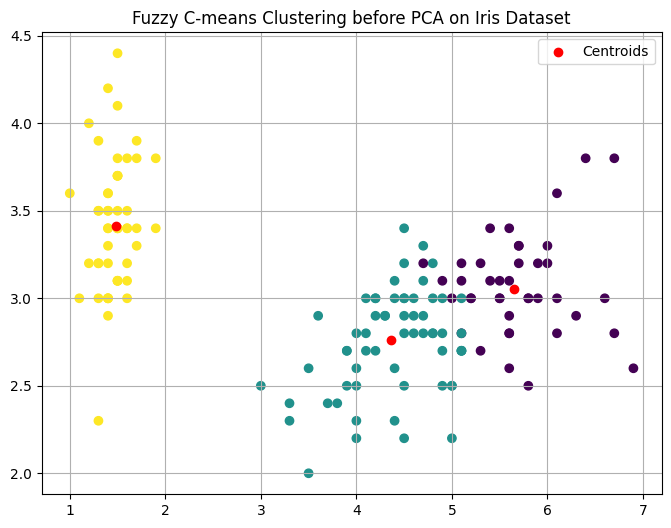

In [ ]:
# X = X_iris[:, :2]  # Taking only the first two features for visualization

# Apply Fuzzy C-means clustering on reduced data
cluster_labels, centers = fuzzy_cmeans(X_iris)

# Plotting the clustered results
plt.figure(figsize=(8, 6))
plt.scatter(X_iris[:, 2], X_iris[:, 1], c=cluster_labels)
plt.scatter(centers[:, 2], centers[:, 1], marker='o', c='red', label='Centroids')
plt.title('Fuzzy C-means Clustering before PCA on Iris Dataset')
plt.legend()
plt.grid(True)
plt.show()

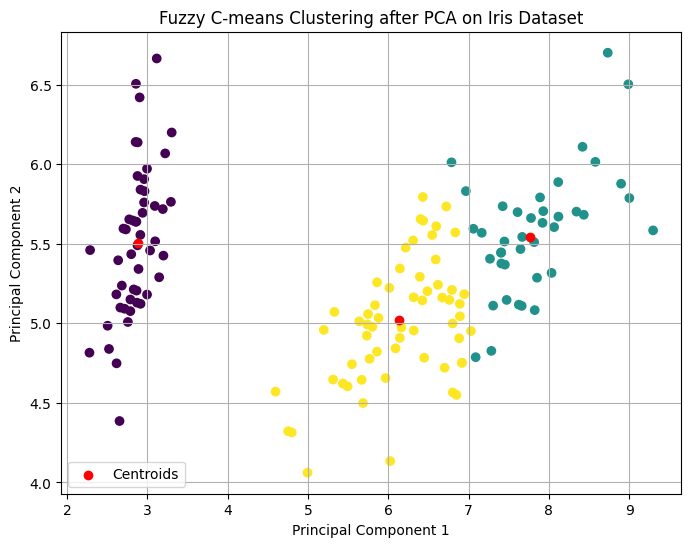

In [ ]:
# Apply PCA
reduced_data, Q, eigenvalues = pca(X_iris, num_components=3)

# Apply Fuzzy C-means clustering on reduced data
cluster_labels, centers = fuzzy_cmeans(reduced_data)

# Plotting the clustered results
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels)
plt.scatter(centers[:, 0], centers[:, 1], marker='o', c='red', label='Centroids')
plt.title('Fuzzy C-means Clustering after PCA on Iris Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

# Report

### PCA
- As we increase the number of principal components, the image becomes more clear and closer to the original.

- As per the explained variance and the images above, the suitable number of principal components that reduce the dimensionality yet does not change the original features too much is **350-400 components**

### Fuzzy clustering before PCA
- The clustering process showed not very good results, apparently because the most important and least important features were used equally.

### Fuzzy clustering after PCA
- The clustering process showed very good results compared to before applying the PCA, because the clustering process here used the most important features.